In [15]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
# from tensorflow import keras as k

In [3]:
path = r'C:\\Users\\Administrator\\Desktop\elephant\\OCR_test\\20190309162316.png'

def cv_show(img, name):
    cv2.imshow(name, img)
    cv2.waitKey()
    cv2.destroyAllWindows()

In [4]:
img = cv2.imread(path)
cv_show(img, 'img')

In [58]:
imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# print(imgGray.shape)
imgGray_r = cv2.resize(imgGray,(342,514))
#shape是按高宽显示，resize是按宽高显示(cv2里全是宽高，shape是numpy自带函数，按行列数也就是高宽显示)，正好相反
print(imgGray_r.shape)
cv_show(imgGray_r,'imgGray_r')

(514, 342)


In [61]:
kernel = np.ones((5,5),np.uint8)

imgcropped = imgGray_r[152:495, 67:253]    #切割图像中的一部分，此处按numpy的规则--先高后宽：从上到下，从左到右
# cv2.putText(imgcropped,"cute lady",(50,150),cv2.FONT_ITALIC,3,(255,0,255,1))
imgcanny = cv2.Canny(imgcropped,150,200)    #寻找图像边缘
imgDilation = cv2.dilate(imgcropped,kernel,iterations=1)    #膨胀操作
imgEroded = cv2.erode(imgDilation,kernel,iterations=1)    #腐蚀操作

# cv_show(imgcropped,'imgcropped')
# cv_show(imgcanny,'imgcanny')
# cv_show(imgDilation,'imgDilation')
# cv_show(imgEroded,'imgEroded')

***以下利用高斯金字塔上下采样***

In [7]:
up = cv2.pyrUp(imgGray_r)    #上采样：将图像在每个方向扩大为原来的两倍，新增的行列以0填充
# cv_show(up,'pyrUP')

In [8]:
down = cv2.pyrDown(imgGray_r)    #降采样
# cv_show(down,'pyrDown')

In [9]:
up_down = cv2.pyrUp(down)
# cv_show(up_down,'pyrup_down')

In [10]:
cv_show(np.hstack((imgGray_r, up_down,imgGray_r-up_down)),'compare')    #hstack是并排放置，vstack是纵排放置
#imgGray_r-up_down  这里进行了一次拉普拉斯金字塔采样

In [65]:
img_d = cv2.resize(img,(342,514))
img_C = img_d.copy()    #一定要copy原图再处理，不然会修改原图
ret, thresh = cv2.threshold(imgGray_r,127,255,cv2.THRESH_BINARY)    #阈值设置为127，超过该值则将像素点置为255，未超过则置为0
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# cv_show(thresh,'thresh')
res = cv2.drawContours(img_C, contours, -1, (0,0,255), 1)    #图像、第几条轮廓线(-1代表所有的)、图像索引、轮廓颜色、轮廓粗细
# x,y,w,h = cv2.boundingRect(contours[425])    #把某个轮廓线用矩形框起来，也可以用圆形框，改改函数就行
# res = cv2.rectangle(res,(x,y),(x+w,y+h),(255,0,0),2)
cv_show(res, 'res')

<font color=black size=5 face=雅黑>***图像直方图***</font>

In [20]:
#整张图片的直方图Hist(一个概念：图像的直方图是用来表现图像中亮度分布的直方图,给出的是图像中某个亮度或者某个范围亮度下共有几个像素)
imgh = cv2.imread(path,0)    #0表示按灰度图读取
hist = cv2.calcHist([imgh],[0],None,[256],[0,256])    
#参数解释：读入的原图；
#通道（[0]代表灰度图，彩图可使用[0][1][2]，数字分别指BGR三个通道）；
#掩模图像，即mask，None表示对整张图做处理，如果仅处理图的一部分则需要自己制作一个掩模使用；
#直方图中箱体的数量
#直方图中每一个箱体的取值范围
hist.shape

(256, 1)

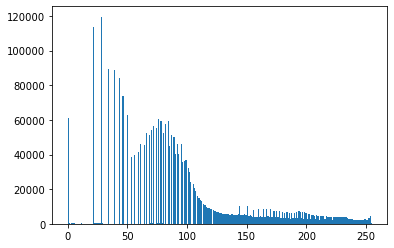

In [16]:
plt.hist(imgh.ravel(),256)    #numpy.ravel()用于将多维数组转换为一维数组
plt.show()

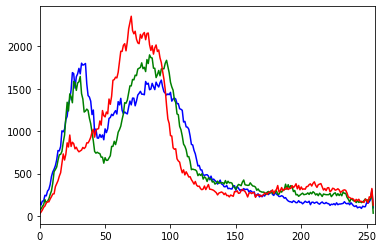

In [42]:
imgc = cv2.imread(path)
imgc = cv2.resize(imgc,(342,514))
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([imgc],[i],None,[256],[0,256])
    plt.plot(histr,color=col)
    plt.xlim([0,256])

***使用掩膜mask***

In [62]:
mask = np.zeros(imgc.shape[:2],np.uint8)
# print(mask.shape)
mask[152:495, 67:253] = 255
# cv_show(mask,'mask')

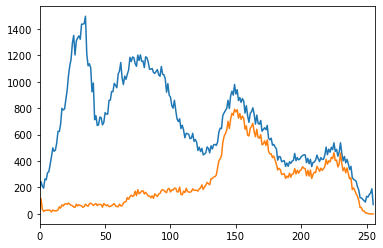

In [68]:
masked_imgc = cv2.bitwise_and(imgc,imgc,mask=mask)    
#对二进制数据进行“与”操作，即对图像（灰度图像或彩色图像均可）每个像素值进行二进制“与”操作，1&1=1，1&0=0，0&1=0，0&0=0
#利用掩膜（mask）进行“与”操作，即掩膜图像白色区域是对需要处理图像像素的保留，黑色区域是对需要处理图像像素的剔除，其余按位操作原理类似只是效果不同而已
# cv_show(masked_imgc,'masked_imgc')
hist_full = cv2.calcHist([imgc],[0],None,[256],[0,256])
hist_mask = cv2.calcHist([imgc],[0],mask,[256],[0,256])
plt.plot(hist_full),plt.plot(hist_mask)
plt.xlim([0,256])
plt.show()

***图像均衡化，可使对比度提高***

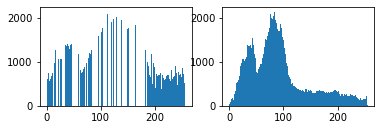

In [78]:
img_equ = cv2.equalizeHist(imgGray_r)    
plt.subplot(221),plt.hist(img_equ.ravel(),256)
plt.subplot(222),plt.hist(imgGray_r.ravel(),256)
plt.show()

In [85]:
res = np.hstack((imgGray_r,img_equ))
cv_show(res,'res')

***自适应均衡化***

In [87]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
res_clahe = clahe.apply(imgGray_r)
res = np.hstack((imgGray_r,img_equ,res_clahe))
cv_show(res,'res')

<font color=black size=5 face=雅黑>**傅里叶变换**</font>